# Normalization scheme for initialization of tensorized neural networks


Author: Alejandro Mata Ali (i3B, Ibermática)

In this notebook we will exemplify the initialization method of tensorized neural networks using the partial norm method with the case of Tensor Train and Tensor Train Matrix layers.

We will use only the following libraries:

- Tensorflow, for the layer definitions.

- Numpy, for other functions.

In [ ]:
#Used libraries
import tensorflow as tf
import numpy as np

# Normalization function

This function is responsible for normalizing the initialization of the tensors of a certain model. It uses the documented iterative normalization algorithm.

It receives a square norm function, made in such a way that it only needs the weights; a partial square norm function, made in such a way that it only needs the weights and the number of nodes used; and the weights, given as a list of tensors.

In [ ]:
def normalizator(norm_f, partial_norm, weights:list, n_factor:float=1,
                 max_iters:int=100, max_tol:float=1e1, min_tol:float=1e-1,
                 verbose:bool=True) -> list:
    '''Function that performs the normalization of the initialization.
    Args:

    Input:
    - norm_f, function: function that calculates the square Frobenius norm.
                        Form f(weights)
    - partial_norm, function: function that calculates the partial square norm.
                                with n nodes. Form f(weights, n)
    - weights,  list: list of weight tensors.
    - n_factor,  float: desired norm.
    - max_iters, int: maximum number of iterations.
    - max_tol, float: maximum value allowed for the norm/n_factor.
    - min_tol, float: minimum value allowed for the norm/n_factor.
    - verbose,  bool: for printing the number of iterations.

    Output:
    - weights, list: tensors updated.'''

    N = len(weights)

    #We calculate the norm
    norm = norm_f(weights)/n_factor
    if   np.isnan(norm):                    finite = 1  #nan
    elif norm < max_tol and norm > min_tol: finite = 0  #in range
    elif norm == np.inf:                    finite = 1  #inf
    elif norm > max_tol:                    finite = 2  #superior
    elif norm == 0:                         finite = -1 #zero
    else:                                   finite = -2 #lower

    #Whether or not it is finite, and whether or not it goes beyond the range.
    if finite == 2 or finite == -2 or finite == 0:
        #We normalize
        for j in range(N): weights[j] = weights[j]/(norm**(1/(2*N)))
        finite = 0
        if verbose: print('0')

    #If it is infinite or zero, we apply normalization until it is in range.
    iters = 0#Iteration counter
    while finite != 0 and iters != max_iters:
        iters += 1
        indic = False #It tells us if we do the normalization in the first step.

        #...
        #Node 0
        #We calculate the partial norm
        norm2 = partial_norm(weights, 0)/n_factor
        if finite == 1 and norm2 > max_tol:#It was infinite and the partial exceeds.
            indic = True                   #We normalize
            if norm2 == np.inf or np.isnan(norm2):#If the partial norm is inf or nan
                factor = ( 10*(1+np.random.rand()) )**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

            else:#If it is finite
                factor = norm2**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

        if finite == -1 and norm2 < min_tol:#It was zero and now falls short.
            indic = True                    #We normalize
            if norm2 == 0:                  #If it is zero
                factor = (0.1/(1+np.random.rand()))**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

            else:#If it is finite
                factor = norm2**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

        #...
        #Nodes 1 to N-1
        if indic == False:
            final = True            #This determines whether N-1 is reached
            for i in range(1,N-1):  #For each node up to N-2
                norm1 = norm2       #Save the previous one
                norm2 = partial_norm(weights, i)/n_factor

                if finite == 1 and norm2 > max_tol:#Infinity and we go too far
                    final = False                         #We finish
                    if norm2 == np.inf or np.isnan(norm2):#Infinite
                        factor = norm1**(1/(2*N))         #We use the previous one
                        for j in range(N): weights[j] = weights[j]/factor
                    else:                                 #Finite
                        factor = norm2**(1/(2*N))
                        for j in range(N): weights[j] = weights[j]/factor
                    break#We finish the for loop

                elif finite == -1 and norm2 < min_tol:#Zero and we fall short.
                    final = False                     #We finish
                    if norm2 == 0:                    #It is zero
                        factor = norm1**(1/(2*N))     #Previous
                        for j in range(N): weights[j] = weights[j]/factor
                    else:                             #It is finite
                        factor = norm2**(1/(2*N))
                        for j in range(N): weights[j] = weights[j]/factor
                    break#We finish the for loop

            #...
            #Final node
            if final == True:#If the thresholds were never exceeded
                factor = norm2**(1/(2*N))#The N-2
                for j in range(N): weights[j] = weights[j]/factor

        #...
        #We calculate the norm in this step, to see if stopping
        norm = norm_f(weights)/n_factor
        if   np.isnan(norm):                    finite = 1  #nan
        elif norm < max_tol and norm > min_tol: finite = 0  #in range
        elif norm == np.inf:                    finite = 1  #inf
        elif norm > max_tol:                    finite = 2  #superior
        elif norm == 0:                         finite = -1 #zero
        else:                                   finite = -2 #lower

        if finite == 2 or finite == -2 or finite == 0: #If it is finite
            factor = norm**(1/(2*N))
            for j in range(N): weights[j] = weights[j]/factor
            finite = 0#We stop
            if verbose: print(iters)

    return weights

# TT Matrix/MPO Layer

Tensor Train Matrix/MPO layer, where we initialize, normalize the parameters and have the forward. We define our own norm and application functions in the build to set the hyperparameters each time.

In [ ]:
class TNLayer_TT_Matrix(tf.keras.layers.Layer):

    def __init__(self, b, p_out,
                 alfa=1, std=0.5, mean=1,
                 name='Layer_TT_Matrix', max_tol=1e60, min_tol=1e-60,
                 activation=None):
        super(TNLayer_TT_Matrix, self).__init__(name=name)
        '''This MPO layer allows to calculate P(x).
        Args:
        - b,       int: bond dimension between nodes.
        - p_out,   int: output dimension for each node.
        - alpha, float: error hyperparameter.
        - std,   float: standard deviation of the initialization.
        - mean,  float: mean of the initialization.
        - name,  float: layer name.
        - max_tol,    float: maximum value for initialization.
        - min_tol,    float: minimum value for initialization.
        - activation, float: activation function.
        '''
        #Hiperparametros
        self.b, self.p_out = b, p_out
        self.alfa, self.std, self.mean = alfa, std, mean
        self.max_tol, self.min_tol = max_tol, min_tol
        self.activation = activation

    def build(self, input_shape):
        '''Function that initializes the hyperparameters and normalizes them
        based on the shape of the input.
           Creates:
           - p_in, int: input dimension per node.
           - N,  int: number of nodes (input and output tensor order).
           - w, list: list of weights.
           - P_x, function: forward function.
           - P_2, function: norm function.
           '''
        #Dimensions of the different nodes of the layer
        self.p_in = input_shape[1]; self.N = len(input_shape)-1
        shape0 = (self.p_in,self.b,self.p_out)#First and last node
        shape1 = (self.p_in,self.b,self.b,self.p_out)#Intermediates

        #We initialize the weights
        self.w = [ tf.Variable(tf.random.normal(shape0, mean=self.mean, stddev=self.std),
                               trainable=True, dtype=float, name='TTMw0') ] +\
            [ tf.Variable(tf.random.normal( shape1, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTMw{i}') for i in range(1,self.N-1) ] +\
            [ tf.Variable(tf.random.normal( shape0, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTMw{self.N-1}') ]

        #We define the functions to be used.
        self.P_x = P_functionMPO(self.N)
        self.P_2 = P_functionMPO2(self.N)

        #We normalize.
        n_factor = (self.p_in*self.p_out)**(self.N/2)
        self.w = normalizator(self.P_2, partial_P_quad, self.w, n_factor=n_factor, max_tol=self.max_tol, min_tol=self.min_tol)

    def call(self, inputs):
        '''Method we call in the layer.
        Its input is an N-tensor of dimension p_in.
        It creates:
        - loss: regularization by norm.
        Output:
        - result, tf.Tensor: result tensor.'''
        #Parallelized call for forward batches
        result = tf.vectorized_map(lambda vec: self.P_x(vec, self.w), inputs)
        #Activation
        if self.activation != None: result = self.activation(result)

        #Rescaled norm factor
        result2 = tf.nn.relu(tf.math.log(self.P_2(self.w)))
        #Metrics
        self.add_metric(result, name='MPO_Px')
        self.add_metric(result2, name='MPO_P2')

        #We obtain a single output
        return tf.reshape(result, tuple([-1,]+[self.p_out,]*self.N))

##Functions

In [ ]:
def TT_function(x, w, N):
    '''This function implements P(x).
    Args:
    - x, tf.Tensor: input N-tensor.
    - w, list: list of tf.Variable weights.
    - N, int: number of nodes.

    Output:
    - node, float: result of P(x).'''
    # . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
    node = tf.tensordot(x, w[0],  axes=([0],[0]))#First contraction
    for i in range(1,N):#Remaining contractions
        node = tf.tensordot(node, w[i],  axes=([0,-2],[0,1]))

    return node

#-------------------------------------------------------------------------
def P_quad(w, N):
    '''Calculate |P|^2
    Args:
    - w, list: list of tf.Variable of weights.
    - N, int: number of nodes.

    Output:
    - node, float: result of the |P|^2.'''
    #We load the weights
    node = tf.tensordot(w[0], w[0],  axes=([2,0],[2,0]))#First contraction
    for i in range(1,N-1):#Intermediate contractions
        node = tf.tensordot(node, w[i],  axes=([0],[1]))
        node = tf.tensordot(node, w[i],  axes=([0,1,3],[1,0,3]))

    #Last contraction
    node = tf.tensordot(node, w[-1],  axes=([0],[1]))
    node = tf.tensordot(node, w[-1],  axes=([0,1,2],[1,0,2]))

    return node

#-------------------------------------------------------------------------
def partial_P_quad(w, N):
    '''We calculate partial |P|^2
    Args:
    - w, list: list of tf.Variable of weights.
    - N, int: number of nodes in the partial norm.

    Output:
    - node, float: result of the |P|^2.'''
    if N == 0:#If only the first node is used.
        node = tf.tensordot(w[0], w[0],  axes=([2,0,1],[2,0,1]))

    else:#If more nodes are used.
        node = tf.tensordot(w[0], w[0],  axes=([2,0],[2,0]))#First contraction
        for i in range(1,N):#All intermediate nodes
            node = tf.tensordot(node, w[i],  axes=([0],[1]))
            node = tf.tensordot(node, w[i],  axes=([0,1,3],[1,0,3]))

        #Last node
        node = tf.tensordot(node, w[N],  axes=([0],[1]))
        node = tf.tensordot(node, w[N],  axes=([0,1,3,2],[1,0,3,2]))

    return node

# TT/MPS Layer

In [ ]:
class TNLayer_MPS(tf.keras.layers.Layer):

    def __init__(self, b, p_out, N_out,
                 alfa=1, std=0.5, mean=1,
                 name='Layer_TT', max_tol=1e60, min_tol=1e-60,
                 activation=None):
        super(TNLayer_MPS, self).__init__(name=name)
        '''This MPS layer allows to calculate P(x).
        Args:
        - b, int: bond dimension between nodes.
        - p_out, int: output dimension for each node.
        - N_out, int: number of output nodes.
        - alpha, float: error hyperparameter.
        - std, float: standard deviation of the initialization.
        - mean, float: mean of the initialization.
        - name, float: layer name.
        - max_tol, float: maximum value for initialization.
        - min_tol, float: minimum value for initialization.
        - activation, float: activation function.
        '''
        #Hyperparameters
        self.b, self.p_out, self.N_out = b, p_out, N_out
        self.alfa, self.std, self.mean = alfa, std, mean
        self.max_tol, self.min_tol = max_tol, min_tol
        self.activation = activation

    def build(self, input_shape):
        '''Function that initializes the hyperparameters and normalizes them
        based on the shape of the input.
           Creates:
           - p_in, int: input dimension per node.
           - N_in, int: number of nodes (input tensor order).
           - N, int: total number of nodes.
           - w, list: list of weights.
           - P_x, function: forward function.
           - P_2, function: norm function.
           '''
        #Dimensions of the different nodes of the layer
        self.p_in = input_shape[1]; self.N_in = len(input_shape)-1
        shape0 = (self.p_in,self.b)#First node
        shape1 = (self.p_in,self.b,self.b)#Intermediate input
        shape2 = (self.p_out,self.b,self.b)#Intermediate output
        shape3 = (self.p_out,self.b)#Final

        #We initialize the weights
        self.w = [ tf.Variable(tf.random.normal(shape0, mean=self.mean, stddev=self.std),
                               trainable=True, dtype=float, name='TTw0') ] +\
            [ tf.Variable(tf.random.normal( shape1, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTw{i}') for i in range(1,self.N_in) ] +\
            [ tf.Variable(tf.random.normal( shape2, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTw{self.N_in+i}') for i in range(self.N_out-1) ] +\
            [ tf.Variable(tf.random.normal( shape3, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTw{self.N_in+self.N_out-1}') ]

        self.N = self.N_in + self.N_out

        #We define the functions to be used.
        self.P_x = P_functionMPS(self.N_in, self.N_out)
        self.P_2 = P_functionMPS2(self.N)

        #We normalize
        n_factor = (self.p_in**self.N_in)*(self.p_out**self.N_out)
        self.w = normalizator(self.P_2, partial_P_MPS_quad, self.w, n_factor=n_factor, max_tol=self.max_tol, min_tol=self.min_tol)

    def call(self, inputs):
        '''Method we call in the layer.
        Its input is an N_in-tensor of dimension p_in.
        It creates:
        - loss: regularization by norm.
        Output:
        - result, tf.Tensor: result tensor.'''
        #Parallelized call for batches
        result = tf.vectorized_map(lambda vec: self.P_x(vec, self.w), inputs)
        #Activation
        if self.activation != None: result = self.activation(result)

        #Rescaled norm factor
        result2 = tf.nn.relu(tf.math.log(self.P_2(self.w)))
        #Metrics
        self.add_metric(result, name='TT_Px')
        self.add_metric(result2, name='TT_P2')

        #We obtain a single output
        return tf.reshape(result, tuple([-1,]+[self.p_out,]*self.N_out))

## Functions

In [ ]:
def MPS_function(x, w, N_in, N_out):
    '''This function implements P(x).
    Args:
    - x, tf.Tensor: input N-tensor.
    - w, list: list of tf.Weights variable.
    - N_in, int: number of input nodes.
    - N_out, int: number of output nodes.

    Output:
    - node, float: result of P(x).'''
    # . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
    node = tf.tensordot(w[0], x, axes=([0],[0]))#First contraction
    for i in range(1,N_in):#Input assembly
        node = tf.tensordot(w[i], node, axes=([0,1],[1,0]))

    node = tf.tensordot(node, w[N_in], axes=([0], [1]))#First output node
    for i in range(N_in+1,N_out+N_in):#Output assembly
        node = tf.tensordot(w[i], node, axes=([1], [1]))

    return node

#-------------------------------------------------------------------------
def P_quad_MPS(w, N):
    '''Calculate |P|^2
    Args:
    - w, list: list of tf.Variable of weights.
    - N, int: number of nodes.

    Output:
    - node, float: result of the |P|^2.'''
    #We load the weights
    node = tf.tensordot(w[0], w[0],  axes=([0],[0]))#First node
    for i in range(1,N-1):#Intermediate nodes
        node = tf.tensordot(node, w[i],  axes=([0],[1]))
        node = tf.tensordot(node, w[i],  axes=([0,1],[1,0]))

    #Last node
    node = tf.tensordot(node, w[-1],  axes=([0],[1]))
    node = tf.tensordot(node, w[-1],  axes=([0,1],[1,0]))

    return node

#-------------------------------------------------------------------------
def partial_P_MPS_quad(w, N):
    '''We calculate partial |P|^2
    Args:
    - w, list: list of tf.Variable of weights.
    - N, int: number of nodes in the partial norm.

    Output:
    - node, float: result of the |P|^2.'''
    if N == 0:#If the first node is considered
        node = tf.tensordot(w[0], w[0],  axes=([0,1],[0,1]))

    else:#If we use more
        node = tf.tensordot(w[0], w[0],  axes=([0],[0]))#First node
        for i in range(1,N):#Intermediates
            node = tf.tensordot(node, w[i],  axes=([0],[1]))
            node = tf.tensordot(node, w[i],  axes=([0,1],[1,0]))
        #Final Node
        node = tf.tensordot(node, w[N],  axes=([0],[1]))
        node = tf.tensordot(node, w[N],  axes=([0,1,2],[1,0,2]))

    return node

# Conection Functions

These are the functions we will use to create the forwards and norms of the layers.

In [ ]:
def P_functionMPO(N):
    '''MPO forward function.
    Args:
    - N, int: number of nodes.'''
    def function1(vec, w):
        return TT_function(vec, w, N)
    return function1


def P_functionMPO2(N):
    '''MPO norm function.
    Args:
    - N, int: number of nodes.'''
    def function2(w):
        return P_quad(w, N)
    return function2

def P_functionMPS(N_in, N_out):
    '''MPS forward function.
    Args:
    - N_in, int: number of input nodes.
    - N_out, int: number of output nodes.'''
    def function3(vec, w):
        return MPS_function(vec, w, N_in, N_out)
    return function3


def P_functionMPS2(N):
    '''MPO norm function.
    Args:
    - N, int: number of nodes.'''
    def function4(w):
        return P_quad_MPS(w, N)
    return function4

# Test

In this part we can see, for some hyperparameters we want, how many iterations we need for normalization.

In [ ]:
#Parameters
N_in = 10
p_in = 4

N_fin = 10
p_fin = 4

b = 20

std  = 0.5
mean = 1

#MPS Layer
layer = TNLayer_MPS(b, p_fin, N_fin, std=std, mean=mean, name='Layer_TT', max_tol=1e3, min_tol=1e-3)

#Initialization
print('We need the following number of normalization steps: ')
a = layer(tf.keras.Input(shape=(p_in,)*N_in))

We need the following number of normalization steps: 
5


In [ ]:
#Parameters
N_in = 15
p_in = 4

b = 50

std  = 0.5
mean = 1

#MPO Layer
layer = TNLayer_TT_Matrix(b, p_fin, std=std, mean=mean, name='Layer_TT_Matrix_1', max_tol=1e3, min_tol=1e-3)

#Initialization
print('We need the following number of normalization steps: ')
a = layer(tf.keras.Input(shape=(p_in,)*N_in))

We need the following number of normalization steps: 
6


# Extended Test


We want to check the scaling of the number of iterations with the size of the tensor network.

## Functions

In [ ]:
def normalizator_pr(norm_f, partial_norm, weights:list, n_factor:float=1,
                 max_iters:int=30, max_tol:float=1e1, min_tol:float=1e-1,
                 verbose:bool=True):
    '''Function that performs the normalization of the initialization.
    Args:

    Input:
    - norm_f, function: function that calculates the square Frobenius norm.
                        Form f(weights)
    - partial_norm, function: function that calculates the partial square norm.
                                with n nodes. Form f(weights, n)
    - weights,  list: list of weight tensors.
    - n_factor,  float: desired norm.
    - max_iters, int: maximum number of iterations.
    - max_tol, float: maximum value allowed for the norm/n_factor.
    - min_tol, float: minimum value allowed for the norm/n_factor.
    - verbose,  bool: for printing the number of iterations.

    Output:
    - weights, list: tensors updated.'''

    N = len(weights)

    #We calculate the norm
    norm = norm_f(weights)/n_factor
    if   np.isnan(norm):                    finite = 1  #nan
    elif norm < max_tol and norm > min_tol: finite = 0  #in range
    elif norm == np.inf:                    finite = 1  #inf
    elif norm > max_tol:                    finite = 2  #superior
    elif norm == 0:                         finite = -1 #zero
    else:                                   finite = -2 #lower

    #Whether or not it is finite, and whether or not it goes beyond the range.
    if finite == 2 or finite == -2 or finite == 0:
        #We normalize
        for j in range(N): weights[j] = weights[j]/(norm**(1/(2*N)))
        finite = 0

    #If it is infinite or zero, we apply normalization until it is in range.
    iters = 0#Iteration counter
    while finite != 0 and iters != max_iters:
        iters += 1
        indic = False #It tells us if we do the normalization in the first step.

        #...
        #Node 0
        #We calculate the partial norm
        norm2 = partial_norm(weights, 0)/n_factor
        if finite == 1 and norm2 > max_tol:#It was infinite and the partial exceeds.
            indic = True                   #We normalize
            if norm2 == np.inf or np.isnan(norm2):#If the partial norm is inf or nan
                factor = ( 10*(1+np.random.rand()) )**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

            else:#If it is finite
                factor = norm2**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

        if finite == -1 and norm2 < min_tol:#It was zero and now falls short.
            indic = True                    #We normalize
            if norm2 == 0:                  #If it is zero
                factor = (0.1/(1+np.random.rand()))**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

            else:#If it is finite
                factor = norm2**(1/(2*N))
                for j in range(N): weights[j] = weights[j]/factor

        #...
        #Nodes 1 to N-1
        if indic == False:
            final = True            #This determines whether N-1 is reached
            for i in range(1,N-1):  #For each node up to N-2
                norm1 = norm2       #Save the previous one
                norm2 = partial_norm(weights, i)

                if finite == 1 and norm2 > max_tol:#Infinity and we go too far
                    final = False                         #We finish
                    if norm2 == np.inf or np.isnan(norm2):#Infinite
                        factor = norm1**(1/(2*N))         #We use the previous one
                        for j in range(N): weights[j] = weights[j]/factor
                    else:                                 #Finite
                        factor = norm2**(1/(2*N))
                        for j in range(N): weights[j] = weights[j]/factor
                    break#We finish the for loop

                elif finite == -1 and norm2 < min_tol:#Zero and we fall short.
                    final = False                     #We finish
                    if norm2 == 0:                    #It is zero
                        factor = norm1**(1/(2*N))     #Previous
                        for j in range(N): weights[j] = weights[j]/factor
                    else:                             #It is finite
                        factor = norm2**(1/(2*N))
                        for j in range(N): weights[j] = weights[j]/factor
                    break#We finish the for loop

            #...
            #Final node
            if final == True:#If the thresholds were never exceeded
                factor = norm2**(1/(2*N))#The N-2
                for j in range(N): weights[j] = weights[j]/factor

        #...
        #We calculate the norm in this step, to see if stopping
        norm = norm_f(weights)/n_factor
        if   np.isnan(norm):                    finite = 1  #nan
        elif norm < max_tol and norm > min_tol: finite = 0  #in range
        elif norm == np.inf:                    finite = 1  #inf
        elif norm > max_tol:                    finite = 2  #superior
        elif norm == 0:                         finite = -1 #zero
        else:                                   finite = -2 #lower

        if finite == 2 or finite == -2 or finite == 0: #If it is finite
            factor = norm**(1/(2*N))
            for j in range(N): weights[j] = weights[j]/factor
            finite = 0#We stop

    return weights, iters

In [ ]:
class TNLayer_TT_Matrix_pr(tf.keras.layers.Layer):

    def __init__(self, b, p_out,
                 alfa=1, std=0.5, mean=1,
                 name='Layer_TT_Matrix', max_tol=1e60, min_tol=1e-60,
                 activation=None):
        super(TNLayer_TT_Matrix_pr, self).__init__(name=name)
        '''This MPO layer allows to calculate P(x).
        Args:
        - b,       int: bond dimension between nodes.
        - p_out,   int: output dimension for each node.
        - alpha, float: error hyperparameter.
        - std,   float: standard deviation of the initialization.
        - mean,  float: mean of the initialization.
        - name,  float: layer name.
        - max_tol,    float: maximum value for initialization.
        - min_tol,    float: minimum value for initialization.
        - activation, float: activation function.
        '''
        #Hiperparametros
        self.b, self.p_out = b, p_out
        self.alfa, self.std, self.mean = alfa, std, mean
        self.max_tol, self.min_tol = max_tol, min_tol
        self.activation = activation

    def build(self, input_shape):
        '''Function that initializes the hyperparameters and normalizes them
        based on the shape of the input.
           Creates:
           - p_in, int: input dimension per node.
           - N,  int: number of nodes (input and output tensor order).
           - w, list: list of weights.
           - P_x, function: forward function.
           - P_2, function: norm function.
           '''
        #Dimensions of the different nodes of the layer
        self.p_in = input_shape[1]; self.N = len(input_shape)-1
        shape0 = (self.p_in,self.b,self.p_out)#First and last node
        shape1 = (self.p_in,self.b,self.b,self.p_out)#Intermediates

        #We initialize the weights
        self.w = [ tf.Variable(tf.random.normal(shape0, mean=self.mean, stddev=self.std),
                               trainable=True, dtype=float, name='TTMw0') ] +\
            [ tf.Variable(tf.random.normal( shape1, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTMw{i}') for i in range(1,self.N-1) ] +\
            [ tf.Variable(tf.random.normal( shape0, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTMw{self.N-1}') ]

        #We define the functions to be used.
        self.P_x = P_functionMPO(self.N)
        self.P_2 = P_functionMPO2(self.N)

        #We normalize.
        n_factor = (self.p_in*self.p_out)**(self.N/2)
        self.w, self.steps = normalizator_pr(self.P_2, partial_P_quad, self.w, n_factor=n_factor, max_tol=self.max_tol, min_tol=self.min_tol)

    def call(self, inputs):
        '''Empty'''
        return self.steps

In [ ]:
class TNLayer_MPS_pr(tf.keras.layers.Layer):

    def __init__(self, b, p_out, N_out,
                 alfa=1, std=0.5, mean=1,
                 name='Layer_TT', max_tol=1e60, min_tol=1e-60,
                 activation=None):
        super(TNLayer_MPS_pr, self).__init__(name=name)
        '''This MPS layer allows to calculate P(x).
        Args:
        - b, int: bond dimension between nodes.
        - p_out, int: output dimension for each node.
        - N_out, int: number of output nodes.
        - alpha, float: error hyperparameter.
        - std, float: standard deviation of the initialization.
        - mean, float: mean of the initialization.
        - name, float: layer name.
        - max_tol, float: maximum value for initialization.
        - min_tol, float: minimum value for initialization.
        - activation, float: activation function.
        '''
        #Hyperparameters
        self.b, self.p_out, self.N_out = b, p_out, N_out
        self.alfa, self.std, self.mean = alfa, std, mean
        self.max_tol, self.min_tol = max_tol, min_tol
        self.activation = activation

    def build(self, input_shape):
        '''Function that initializes the hyperparameters and normalizes them
        based on the shape of the input.
           Creates:
           - p_in, int: input dimension per node.
           - N_in, int: number of nodes (input tensor order).
           - N, int: total number of nodes.
           - w, list: list of weights.
           - P_x, function: forward function.
           - P_2, function: norm function.
           '''
        #Dimensions of the different nodes of the layer
        self.p_in = input_shape[1]; self.N_in = len(input_shape)-1
        shape0 = (self.p_in,self.b)#First node
        shape1 = (self.p_in,self.b,self.b)#Intermediate input
        shape2 = (self.p_out,self.b,self.b)#Intermediate output
        shape3 = (self.p_out,self.b)#Final

        #We initialize the weights
        self.w = [ tf.Variable(tf.random.normal(shape0, mean=self.mean, stddev=self.std),
                               trainable=True, dtype=float, name='TTw0') ] +\
            [ tf.Variable(tf.random.normal( shape1, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTw{i}') for i in range(1,self.N_in) ] +\
            [ tf.Variable(tf.random.normal( shape2, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTw{self.N_in+i}') for i in range(self.N_out-1) ] +\
            [ tf.Variable(tf.random.normal( shape3, mean=self.mean, stddev=self.std),
                          trainable=True, dtype=float, name=f'TTw{self.N_in+self.N_out-1}') ]

        self.N = self.N_in + self.N_out

        #We define the functions to be used.
        self.P_x = P_functionMPS(self.N_in, self.N_out)
        self.P_2 = P_functionMPS2(self.N)

        #We normalize
        n_factor = (self.p_in**self.N_in)*(self.p_out**self.N_out)
        self.w, self.steps = normalizator_pr(self.P_2, partial_P_MPS_quad, self.w, n_factor=n_factor, max_tol=self.max_tol, min_tol=self.min_tol)

    def call(self, inputs):
        '''Empty'''
        return self.steps

## Test function

In [ ]:
def MPS_test(N_max, p_max, b_max, N_min=4, p_min=2, b_min=10):
    '''Function for testing the MPS layers.'''
    std  = 0.5
    mean = 1
    steps = np.zeros((N_max-N_min, p_max-p_min, b_max-b_min))
    for N in range(N_min, N_max):
        for p in range(p_min, p_max):
            for b in range(b_min, b_max):
                Input = tf.keras.Input(shape=(p,)*(N//2))
                layer = TNLayer_MPS_pr(b, p, N-(N//2), std=std, mean=mean, max_tol=1e3, min_tol=1e-3)
                a = layer(Input)
                steps[N-N_min, p-p_min, b-b_min] = layer.steps

    return steps


def MPO_test(N_max, p_max, b_max, N_min=4, p_min=2, b_min=10):
    '''Function for testing the MPO layers.'''
    std  = 0.5
    mean = 1
    steps = np.zeros((N_max-N_min, p_max-p_min, b_max-b_min))
    for N in range(N_min, N_max):
        for p in range(p_min, p_max):
            for b in range(b_min, b_max):
                Input = tf.keras.Input(shape=(p,)*N)
                layer = TNLayer_TT_Matrix_pr(b, p, std=std, mean=mean, max_tol=1e3, min_tol=1e-3)
                a = layer(Input)
                steps[N-N_min, p-p_min, b-b_min] = layer.steps

    return steps

## Test

### MPS

In [ ]:
N_max = 30
p_max = 6
b_max = 11

N_min = 10
p_min = 2
b_min = 10

stepss = MPS_test(N_max, p_max, b_max, N_min=N_min, p_min=p_min, b_min=b_min)

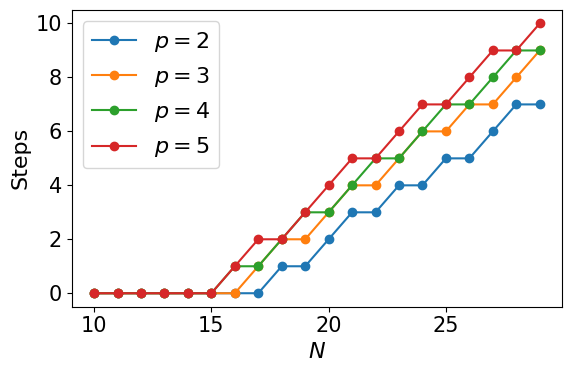

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams.update( {'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.size': 16} )

plt.figure('Steps N', figsize = (6, 4))
plt.xlabel('$N$'); plt.ylabel('Steps')
for i in range(p_min, p_max):
    if i%1 == 0:
        plt.plot(np.arange(N_min, N_max), stepss[:,i-p_min,-1], 'o-', label=f'$p={i}$')

plt.legend(loc='upper left')
plt.tight_layout();
plt.savefig('Steps_VS_Size_MPS.pdf')
plt.show()

In [ ]:
N_max2 = 26
p_max2 = 30
b_max2 = 11

N_min2 = 25
p_min2 = 2
b_min2 = 10

stepss2 = MPS_test(N_max2, p_max2, b_max2, N_min=N_min2, p_min=p_min2, b_min=b_min2)

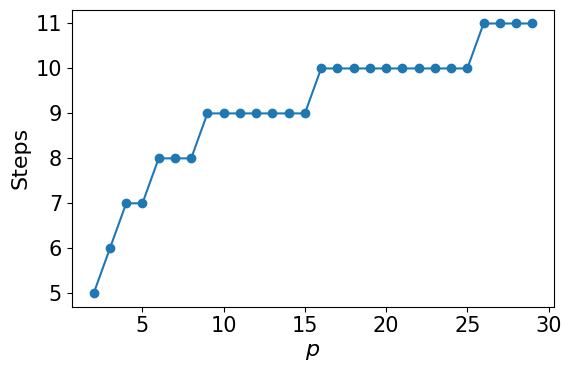

In [ ]:
plt.figure('Steps p', figsize = (6, 4))
plt.xlabel('$p$'); plt.ylabel('Steps')
for i in range(N_min2, N_max2):
    plt.plot(np.arange(p_min2, p_max2), stepss2[i-N_min2,:,-1], 'o-')

plt.tight_layout();
plt.savefig('Steps_VS_Size_N_25_MPS.pdf')
plt.show()

In [ ]:
N_max3 = 21
p_max3 = 4
b_max3 = 31

N_min3 = 20
p_min3 = 3
b_min3 = 2

stepss3 = MPS_test(N_max3, p_max3, b_max3, N_min=N_min3, p_min=p_min3, b_min=b_min3)

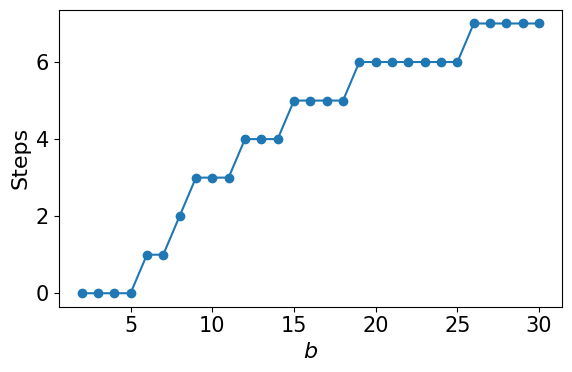

In [ ]:
plt.figure('Steps p', figsize = (6, 4))
plt.xlabel('$b$'); plt.ylabel('Steps')
plt.plot(np.arange(b_min3, b_max3), stepss3[-1,-1,:], 'o-')

plt.tight_layout();
plt.savefig('Steps_VS_Size_N_20_p_3_MPS.pdf')
plt.show()

### MPO

In [ ]:
N_max = 30
p_max = 6
b_max = 11

N_min = 10
p_min = 2
b_min = 10

stepso = MPO_test(N_max, p_max, b_max, N_min=N_min, p_min=p_min, b_min=b_min)

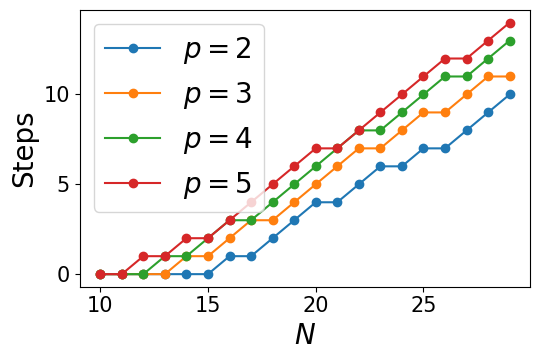

In [ ]:
plt.figure('Steps N', figsize = (6, 4))
plt.xlabel('$N$'); plt.ylabel('Steps')
for i in range(p_min, p_max):
    if i%1 == 0:
        plt.plot(np.arange(N_min, N_max), stepso[:,i-p_min,-1], 'o-', label=f'$p={i}$')

plt.legend(loc='upper left')
plt.tight_layout();
plt.savefig('Steps_VS_Size_MPO.pdf')
plt.show()

In [ ]:
N_max2 = 26
p_max2 = 30
b_max2 = 11

N_min2 = 25
p_min2 = 2
b_min2 = 10

stepso2 = MPO_test(N_max2, p_max2, b_max2, N_min=N_min2, p_min=p_min2, b_min=b_min2)

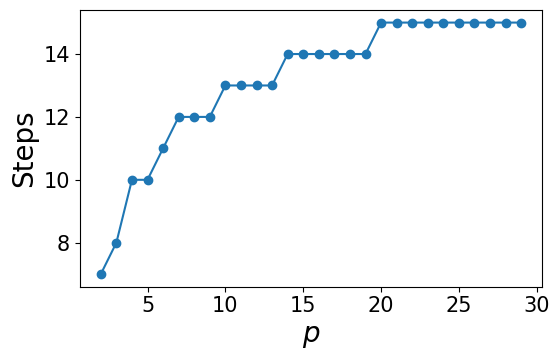

In [ ]:
plt.figure('Steps p', figsize = (6, 4))
plt.xlabel('$p$'); plt.ylabel('Steps')
for i in range(N_min2, N_max2):
    plt.plot(np.arange(p_min2, p_max2), stepso2[i-N_min2,:,-1], 'o-')

plt.tight_layout();
plt.savefig('Steps_VS_Size_N_25_MPO.pdf')
plt.show()

In [ ]:
N_max3 = 21
p_max3 = 4
b_max3 = 31

N_min3 = 20
p_min3 = 3
b_min3 = 2

stepso3 = MPO_test(N_max3, p_max3, b_max3, N_min=N_min3, p_min=p_min3, b_min=b_min3)

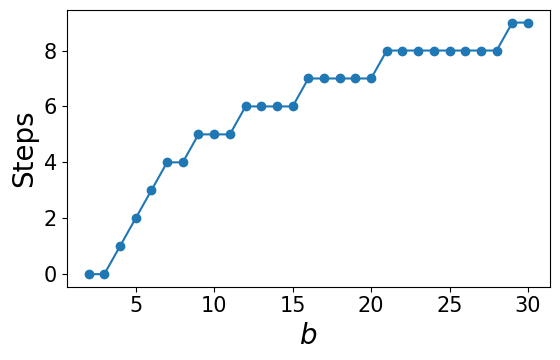

In [ ]:
plt.figure('Steps p', figsize = (6, 4))
plt.xlabel('$b$'); plt.ylabel('Steps')
plt.plot(np.arange(b_min3, b_max3), stepso3[-1,-1,:], 'o-')

plt.tight_layout();
plt.savefig('Steps_VS_Size_N_20_p_3_MPO.pdf')
plt.show()

### All

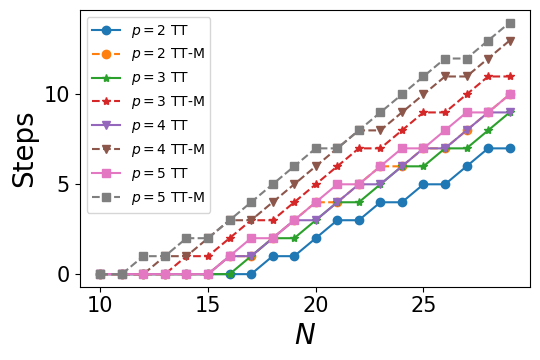

In [ ]:
rcParams.update( {'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.size': 20} )

plt.figure('Steps N', figsize = (6, 4))
plt.xlabel('$N$'); plt.ylabel('Steps')
symbols = ['o', '*', 'v', 's']
for i in range(p_min, p_max):
        plt.plot(np.arange(N_min, N_max), stepss[:,i-p_min,-1], symbols[i-p_min]+'-', label=f'$p={i}$ TT')
        plt.plot(np.arange(N_min, N_max), stepso[:,i-p_min,-1], symbols[i-p_min]+'--', label=f'$p={i}$ TT-M')

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout();
plt.savefig('Steps_VS_Size.pdf')
plt.show()

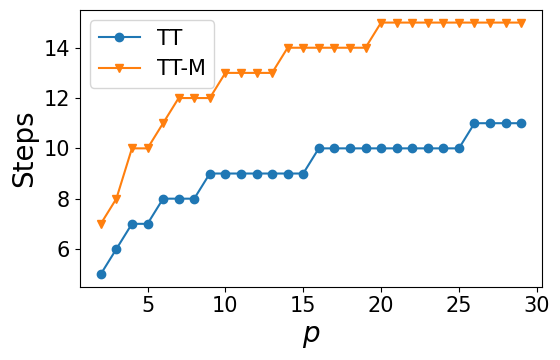

In [ ]:
plt.figure('Steps p', figsize = (6, 4))
plt.xlabel('$p$'); plt.ylabel('Steps')
for i in range(N_min2, N_max2):
    plt.plot(np.arange(p_min2, p_max2), stepss2[i-N_min2,:,-1], 'o-', label='TT')
    plt.plot(np.arange(p_min2, p_max2), stepso2[i-N_min2,:,-1], 'v-', label='TT-M')

plt.legend(loc='upper left', fontsize=15)
plt.tight_layout();
plt.savefig('Steps_VS_Size_N_25.pdf')
plt.show()

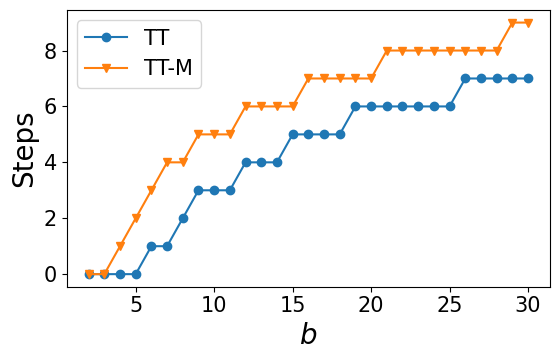

In [ ]:
plt.figure('Steps p', figsize = (6, 4))
plt.xlabel('$b$'); plt.ylabel('Steps')
plt.plot(np.arange(b_min3, b_max3), stepss3[-1,-1,:], 'o-', label='TT')
plt.plot(np.arange(b_min3, b_max3), stepso3[-1,-1,:], 'v-', label='TT-M')

plt.legend(loc='upper left', fontsize=15)
plt.tight_layout();
plt.savefig('Steps_VS_Size_N_20_p_3.pdf')
plt.show()